In [ ]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 5.0 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
from scipy.io import loadmat
import math

In [ ]:
class Conv3d_cd(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=1, dilation=1, groups=1, bias=False, theta=0.7):

        super(Conv3d_cd, self).__init__() 
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.theta = theta

    def forward(self, x):
        out_normal = self.conv(x)


        if math.fabs(self.theta - 0.0) < 1e-8:
            return out_normal 
        else:
            #pdb.set_trace()
            [C_out,C_in, kernel_size,kernel_size,depth] = self.conv.weight.shape
            kernel_diff = self.conv.weight.sum(2).sum(2)
            kernel_diff = kernel_diff[:, :, None, None]
            kernel_diff = kernel_diff.repeat(1,1,3,3,1)
            out_diff = F.conv3d(input=x, weight=kernel_diff, bias=self.conv.bias, stride=self.conv.stride, padding=self.conv.padding, groups=self.conv.groups)

            return out_normal - self.theta * out_diff

In [ ]:
class CNN(nn.Module):
    def __init__(self, FM, Classes, patchsize, NC):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            Conv3d_cd(
                in_channels = 1,
                out_channels = FM,
                kernel_size = (3, 3, 3),
                stride = 1,
                padding = (0,0,0)
            ),
            nn.BatchNorm3d(FM),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1,1,2)),
#             nn.Dropout(0.5),
        )
        self.final_bands = (NC - 2) // 2
        
        self.conv2 = nn.Sequential(
            Conv3d_cd(FM, FM*2, (3, 3, 3 ), 1, (0,0,0)),
            nn.BatchNorm3d(FM*2),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1,1,2))

        )
        self.final_bands = (self.final_bands - 2) // 2
        self.conv3 = nn.Sequential(
            Conv3d_cd(FM*2, FM*4, (3, 3, 3), 1, (0,0,0)),
            nn.BatchNorm3d(FM*4),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1,1,2))

        )
        self.final_bands = (self.final_bands - 2) // 2
        
        self.final_patch_size = patchsize - 6
        
        print(self.final_bands)
        print(self.final_patch_size)
        self.out1 =  nn.Linear(self.final_patch_size * self.final_patch_size * FM * 4 * self.final_bands, Classes)
        
    def forward(self, x1):
        x1 = x1.unsqueeze(1)
        x1 = self.conv1(x1)
        x1 = self.conv2(x1)
        x1 = self.conv3(x1)
        x1 = x1.reshape(x1.shape[0], -1)  
        out1 = self.out1(x1)
        return out1

In [ ]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
from scipy.io import loadmat
# 地物类别
class_num = 16
X = sio.loadmat('/content/drive/MyDrive/AI data/paviaU/Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('/content/drive/MyDrive/AI data/paviaU/Indian_pines_gt.mat')['indian_pines_gt']

# 用于测试样本的比例
test_ratio = 0.90
# 每个像素周围提取 patch 的尺寸
patch_size = 11
# 使用 PCA 降维，得到主成分的数量
pca_components = 30

print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, numComponents=pca_components)
print('Data shape after PCA: ', X_pca.shape)

print('\n... ... create data cubes ... ...')
X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)
print('Data cube X shape: ', X_pca.shape)
print('Data cube y shape: ', y.shape)

print('\n... ... create train & test data ... ...')
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, test_ratio)
print('Xtrain shape: ', Xtrain.shape)
print('Xtest  shape: ', Xtest.shape)


Hyperspectral data shape:  (145, 145, 200)
Label shape:  (145, 145)

... ... PCA tranformation ... ...
Data shape after PCA:  (145, 145, 30)

... ... create data cubes ... ...
Data cube X shape:  (10249, 11, 11, 30)
Data cube y shape:  (10249,)

... ... create train & test data ... ...
Xtrain shape:  (1024, 11, 11, 30)
Xtest  shape:  (9225, 11, 11, 30)


In [ ]:
print(ytest)
print(ytest.shape)

[12.  2. 13. ... 15. 14. 13.]
(9225,)


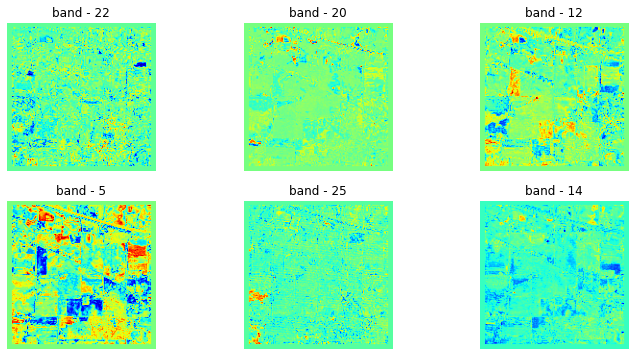

In [ ]:
import seaborn as sns
sns.axes_style('whitegrid')
fig = plt.figure(figsize=(12, 6))

# 不同光谱下的图像示例
for i in range(1, 1+6):
    fig.add_subplot(2, 3, i)
    q = np.random.randint(X.shape[2])#随机选择六个波段
    #print(q)
    plt.imshow(X[:, :, q], cmap='jet')
    plt.axis('off')
    plt.title(f'band - {q}')

In [ ]:
class TrainDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
testset  = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=32, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=32, shuffle=False, num_workers=2)

In [ ]:
# 随机输入，测试网络结构是否通
x = torch.randn(55, 11, 11, 30)
net = CNN(16,16,11,30)
y = net(x)
print(y.shape)

2
5
torch.Size([55, 16])


In [ ]:
def train(net):


  current_loss_his = []
  current_Acc_his = []

  best_net_wts = copy.deepcopy(net.state_dict())
  best_acc = 0.0

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  # 开始训练
  total_loss = 0
  for epoch in range(100):
      net.train()  # 将模型设置为训练模式
      for i, (inputs, labels) in enumerate(train_loader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          # 优化器梯度归零
          optimizer.zero_grad()
          # 正向传播 +　反向传播 + 优化 
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      net.eval()   # 将模型设置为验证模式
      current_acc = test_acc(net)
      current_Acc_his.append(current_acc)

      if current_acc > best_acc:
        best_acc = current_acc
        best_net_wts = copy.deepcopy(net.state_dict())

      print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]  [current acc: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item(), current_acc))
      current_loss_his.append(loss.item())

  print('Finished Training')
  print("Best Acc:%.4f" %(best_acc))

  # load best model weights
  net.load_state_dict(best_net_wts)

  return net,current_loss_his,current_Acc_his

In [ ]:
def test_acc(net):
  count = 0
  # 模型测试
  for inputs, _ in test_loader:
      inputs = inputs.to(device)
      outputs = net(inputs)
      outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
      if count == 0:
          y_pred_test =  outputs
          count = 1
      else:
          y_pred_test = np.concatenate( (y_pred_test, outputs) )

  # 生成分类报告
  classification = classification_report(ytest, y_pred_test, digits=4)
  index_acc = classification.find('weighted avg')
  accuracy = classification[index_acc+17:index_acc+23]
  return float(accuracy)

In [ ]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 网络放到GPU上
net = CNN(16,16,11,30).to(device)
# 训练
net,current_loss_his,current_Acc_his = train(net)

2
5
[Epoch: 1]   [loss avg: 44.1550]   [current loss: 0.7799]  [current acc: 0.7786]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 2]   [loss avg: 28.8684]   [current loss: 0.2928]  [current acc: 0.8854]
[Epoch: 3]   [loss avg: 21.3411]   [current loss: 0.1461]  [current acc: 0.9463]
[Epoch: 4]   [loss avg: 16.7797]   [current loss: 0.0834]  [current acc: 0.9533]
[Epoch: 5]   [loss avg: 13.8957]   [current loss: 0.2107]  [current acc: 0.9152]
[Epoch: 6]   [loss avg: 11.8847]   [current loss: 0.0641]  [current acc: 0.9380]
[Epoch: 7]   [loss avg: 10.3100]   [current loss: 0.0118]  [current acc: 0.9734]
[Epoch: 8]   [loss avg: 9.0774]   [current loss: 0.0212]  [current acc: 0.9743]
[Epoch: 9]   [loss avg: 8.1200]   [current loss: 0.0063]  [current acc: 0.9709]
[Epoch: 10]   [loss avg: 7.5011]   [current loss: 0.0238]  [current acc: 0.9346]
[Epoch: 11]   [loss avg: 6.8916]   [current loss: 0.0186]  [current acc: 0.9636]
[Epoch: 12]   [loss avg: 6.3487]   [current loss: 0.0325]  [current acc: 0.9739]
[Epoch: 13]   [loss avg: 5.8746]   [current loss: 0.0043]  [current acc: 0.9797]
[Epoch: 14]   [loss avg: 5.462

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
def show_plot(data,plot_name,x_name,y_name):
  plt.title(plot_name)
  plt.xlabel(x_name)
  plt.ylabel(y_name)
  plt.plot(data)

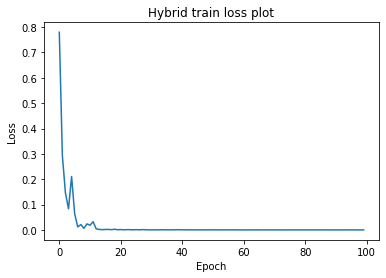

In [ ]:
show_plot(current_loss_his,'Hybrid train loss plot','Epoch','Loss')


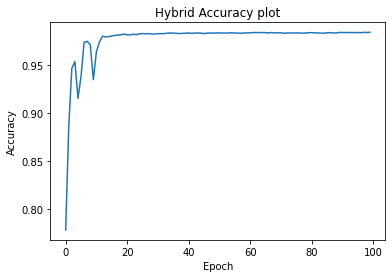

In [ ]:
show_plot(current_Acc_his,'Hybrid Accuracy plot','Epoch','Accuracy')

In [ ]:
net.eval()   # 将模型设置为验证模式
# 测试最好的模型的结果
count = 0
# 模型测试
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)

              precision    recall  f1-score   support

         0.0     1.0000    0.9756    0.9877        41
         1.0     0.9927    0.9479    0.9697      1285
         2.0     0.9515    0.9987    0.9745       747
         3.0     0.9798    0.9108    0.9440       213
         4.0     0.9977    0.9977    0.9977       435
         5.0     0.9985    0.9909    0.9947       657
         6.0     1.0000    1.0000    1.0000        25
         7.0     0.9977    1.0000    0.9988       430
         8.0     1.0000    0.7222    0.8387        18
         9.0     0.9851    0.9829    0.9840       875
        10.0     0.9703    0.9914    0.9808      2210
        11.0     0.9848    0.9738    0.9793       534
        12.0     1.0000    0.9892    0.9946       185
        13.0     0.9956    0.9991    0.9974      1139
        14.0     0.9943    1.0000    0.9971       347
        15.0     0.9651    0.9881    0.9765        84

    accuracy                         0.9835      9225
   macro avg     0.9883   

In [ ]:
# load the original image
X = sio.loadmat('/content/drive/MyDrive/AI data/paviaU/Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('/content/drive/MyDrive/AI data/paviaU/Indian_pines_gt.mat')['indian_pines_gt']

height = y.shape[0]
width = y.shape[1]

X = applyPCA(X, numComponents= pca_components)
X = padWithZeros(X, patch_size//2)

# 逐像素预测类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if int(y[i,j]) == 0:
            continue
        else :
            image_patch = X[i:i+patch_size, j:j+patch_size, :]
            #print(image_patch.shape)
            image_patch = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2])
            #print(image_patch.shape)
            X_test_image = torch.FloatTensor(image_patch.transpose(0, 1, 2, 3)).to(device)                                   
            prediction = net(X_test_image)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i][j] = prediction+1
    if i % 1 == 0:
        print('... ... row ', i, ' handling ... ...')

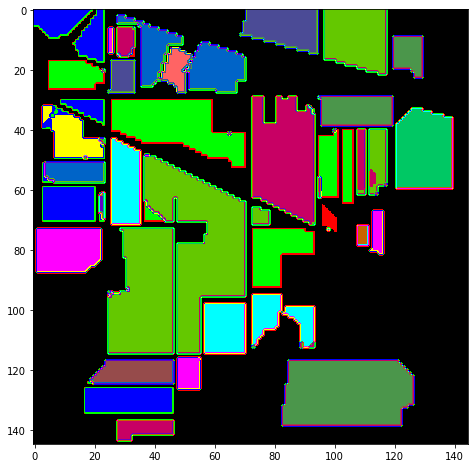

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(12,12))